In [124]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from collections import deque

In [133]:
# Enums
class Color(Enum):
    RED = 0
    BLUE = 1
    YELLOW = 2
    GREEN = 3
    BLACK = 4

class Label(Enum):
    DANGEROUS = 0
    SAFE = 1

COLOR_TO_RGB = {
    0 : (255, 0, 0),
    1 : (0, 0, 255),
    2 : (255, 255, 0),
    3 : (0, 255, 0),
    4 : (0, 0, 0)
}

In [134]:
# Image Generation
class Image: # USE THIS CLASS TO DISPLAY / CREATE IMAGE
    def __init__(self, data, label, third_wire):
        self.data = data
        self.label = label
        self.third_wire = third_wire

    def display(self):
        n = self.data.shape[0]
        image_data = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                curr_val = self.data[i][j]
                image_data[i][j] = COLOR_TO_RGB[curr_val]

        plt.imshow(image_data)
        plt.axis("off")
        plt.show()

class DataSet:
    def __init__(self):
        self.image_data = []
        self.labels = []
        self.third_wires = []

    def add_image(self, image, label, third_wire):
        """Add an image to the dataset using raw data"""
        self.image_data.append(image)
        self.labels.append(label.value)
        self.third_wires.append(third_wire) 

class ImageGenerator:
    """Generates N (M x M) images and writes to data"""
    def __init__(self, num_images, dimensions = 20, write_path = None, dataset = None, seed = None):
        self.dimensions = dimensions
        self.seed = seed
        random.seed(seed)
        for _ in range(num_images):
            data, label, third_wire = self.generate(write_path is not None)
            if dataset is not None:
                dataset.add_image(data, label, third_wire)

            # TODO: Write to data (may not be necessary, gen is really fast)
            if write_path is not None:
                pass

    def generate(self, write_ = False):
        """Generate a single image and label it appropriately"""
        n = self.dimensions
        image_data = np.full((n, n), Color.BLACK.value)
        colors = [Color.RED, Color.BLUE, Color.YELLOW, Color.GREEN]

        # Keep track of rows/cols that can be used
        valid_rows = list(range(n))
        valid_cols = list(range(n))

        # 1  = Color Row
        # -1 = Color Col
        pointer = random.choice([1, -1])
        label = Label.SAFE
        yellow_placed = False
        third_wire = None

        for i in range(4):
            # Select a unused color
            curr_color = random.choice(colors)
            colors.remove(curr_color)

            # Determine which should be cut (if dangerous)
            if i == 2:
                third_wire = curr_color
            
            # Handle marking an image as DANGEROUS if red is placed before yellow
            yellow_placed = yellow_placed or curr_color == Color.YELLOW
            if curr_color == Color.RED and not yellow_placed:
                label = Label.DANGEROUS

            if pointer == 1:
                rand_idx = random.choice(valid_rows)
                valid_rows.remove(rand_idx)
                self.color_row(rand_idx, curr_color, image_data)
            else:
                rand_idx = random.choice(valid_cols)
                valid_cols.remove(rand_idx)
                self.color_column(rand_idx, curr_color, image_data)
                
            pointer *= -1
        
        return image_data, label, third_wire
            

    def color_column(self, col, color, arr):
        """Color the given column of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[i][col] = color.value

    def color_row(self, row, color, arr):
        """Color the given row of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[row][i] = color.value

In [225]:
# Helper Functions
def load_image(dataset_obj, index):
    """Load a specific index of the dataset"""
    image_data = dataset_obj.image_data[index]
    label = dataset_obj.labels[index]
    third_wire = dataset_obj.third_wires[index]
    img = Image(image_data, label, third_wire)
    return img

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def train_test_validation_split(X, y, train_size = .8, test_size = .1, validation_size = .1):
    if train_size + test_size + validation_size != 1:
        print("Error: train + test + validation don't add up to 1.")
        return
    
    examples, features = X.shape
    # Randomize Indexes
    index_array = np.arange(examples)
    random.shuffle(index_array)

    # Split up data
    num_training = int(examples * train_size)
    num_testing = int(examples * test_size)
    train_indices = index_array[:num_training]
    test_indices = index_array[num_training:(num_training + num_testing)]
    validation_indices = index_array[(num_training + num_testing):]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]

    return X_train, y_train, X_test, y_test, X_validation, y_validation
    

def one_hot_encode(image_data):
    """One-Hot encode matrix of examples"""
    if not isinstance(image_data, np.ndarray):
        image_data = np.array(image_data)

    num_colors = 4
    examples, rows, cols = image_data.shape
    encoded_shape = (examples, rows, cols, num_colors)
    encoded_image = np.zeros(encoded_shape)
    for i in range(examples):
        for j in range(rows):
            for k in range(cols):
                for l in range(num_colors):
                    if l == image_data[i, j, k]:
                        encoded_image[i, j, k, l] = 1
                    
    return encoded_image

def apply_convolution(image_data, step_size = 1):
    """Apply convolution"""
    num_images, W, _, C = image_data.shape
    
    # Kernel Initialization
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    K = 3

    output_size = ((W - K) // step_size) + 1
    output = np.zeros((num_images, output_size, output_size, C))

    # For every image
    for n in range(num_images):

        # For every element of the feature map
        for i in range(output_size):
            for j in range(output_size):
                region = image_data[n, i : i + K, j : j + K] # (3, 3, 4) - pixel subregion
                for c in range(C):
                    output[n, i, j, c] += np.sum(kernel * region[:, :, c])
    return relu(output)

def apply_pooling(image_data, P, mode_ = "max"):
    if mode_ not in ["max", "mean"]:
        return -1

    num_images, W, _, C = image_data.shape
    output_size = W // P
    output = np.zeros((num_images, output_size, output_size, C))

    for n in range(num_images):
        for i in range(0, W - P + 1, P):
            for j in range(0, W - P + 1, P):
                region = image_data[n, i : i + P, j : j + P, :] # (3, 3, 4) - pixel subregion
                for c in range(C):
                    func_ = np.max if mode_ == "max" else np.mean
                    output[n, i // P, j // P, c] = func_(region[:, :, c])
    return output

def row_col_features(image_data):
    col_features = np.sum(image_data, axis=1)
    row_features = np.sum(image_data, axis=2)
    return np.concatenate([col_features, row_features], axis=1)
            

def preprocess_data(image_data, label_data):
    """Preprocess and encode image and label data for model training"""
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    flattened_data = image_data.reshape(image_data.shape[0], -1)
    flattened_data = np.c_[np.ones(len(flattened_data)), flattened_data] 
    return flattened_data, label_data

def preprocess_data_plus(image_data, label_data):
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    convolved = apply_convolution(image_data, 1)
    pooled = apply_pooling(convolved, 2, "mean")
    rc_features = row_col_features(image_data)
    
    flattened_raw = image_data.reshape(image_data.shape[0], -1)
    flattened_pooled = pooled.reshape(pooled.shape[0], -1)
    flattened_pooled_squared = np.square(flattened_pooled)
    flattened_rc = rc_features.reshape(rc_features.shape[0], -1)
    flattened_rc_squared = np.square(flattened_rc)

    # EXCLUDE ALL ADDITIONAL FEATURES
    #output = np.concatenate([flattened_raw], axis = 1)
    # EXCLUDE CONV FEATURES
    #output = np.concatenate([flattened_raw, flattened_rc, flattened_rc_squared], axis = 1)
    # EXCLUDE RC FEATURES
    output = np.concatenate([flattened_raw, flattened_pooled, flattened_pooled_squared], axis = 1)
    # USE ALL FEATURES
    #output = np.concatenate([flattened_raw, flattened_pooled, flattened_pooled_squared, flattened_rc, flattened_rc_squared], axis = 1)
    flattened_pooled = np.c_[np.ones(len(output)), output] 
    return flattened_pooled, label_data
    
def plot_data(title, x_label, y_label, data):
    """Data should be either a list or tuple, where the list is a list of tuples.
    
    Tuple format: Data to be plotted, name of data"""
    fig, ax = plt.subplots()
    
    if isinstance(data, list):
        for d in data:
            ax.plot(d[0], label = d[1])
    else:
        ax.plot(data[0], label = data[1])
    ax.set_title(title)
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.show()
    

## Task 1 

Build and train a model on the data set to take as input a wiring diagram and give as output whether or not it is dangerous.

- How are you defining your input space?
  - 20x20 image -> 400-dimension vector (one for each pixel)
    - For each pixel, use one-hot encoding for each possible color (= 1600 features)
  - Convolution layer converting image to 18x18 grid
    - Use mean pooling on convolutional grid to get 9x9 grid 
      - For each cell, four possible colors (9x9x4 = 324 features)
  - W_0 bias term (1 feature)
  - 1600 + 324 + 1 = 1925 features
- How are you defining your output space?
  - Take sigmoid of the predictions (dot product of weights and data) to get a probability from 0 - 1.
  - Use 0.5 as classification threshold (as half will be safe with the other half dangeous) to get a binary classification.
  - 0 = Dangerous; 1 = Safe
- What model space are you considering, and what parameters does it have? Be sure to specify any design choices you make here.
  - Use Logistic Regression. 
  - Parameters: 1 Bias Term + 1600 raw features (cell and color) + 324 convolutional features
    - We use convolutional features as it allows the model to better understand what is going on around a specific pixel. 
    - We used a cross shaped kernel to emphasize instances where a wire may intersect another wire, which would help in determining the situations where a diagram is dangerous
      - The kernal was 3x3 as the model only needs to see its direct neighbors
    - We then condense the data using mean pooling to understand how many colors may be in the surrounding area (better understand intersections)
- How are you measuring the loss or error of a given model?
  - Binary Cross Entropy/Log Loss
- What training algorithm are you using to find the best model you can? Include any necessary math to specify your algorithm.
  - Stochastic Gradient Descent. 
    - Take the derivative of the loss with respect to the weights for one specific datapoint.
- How are you preventing overfitting?
  - We are using L2 Regularization to allow the gradient to explore different possible minima in the hopes to find the global minimum
    - The penalty also has a decay so that as the model goes through more epochs, it stabilizes onto a specific minimum.
  - We also introduced an epsilon hyperparameter which measures how the losses are in respect to the number of epochs
    - If the difference between the average of the last n losses (where n = 5) and the current loss was less than epsilon, we ended there. 

In [233]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization):
        self.n = len(X_train)                                           # of training examples
        self.d = len(X_train[0])                                        # of features
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]         # Training data
        self.X_test = X_test                                            # Testing data
        self.X_val = X_val                                              # Validation data
        self.y_train = y_train                                          # Training classification Labels
        self.y_test = y_test                                            # Testing classification Labels
        self.y_val = y_val                                              # Validation classification Labels
        self.weights = np.zeros(self.d)                                 # Current parameters / weights with d rows
        self.lr = lr                                                    # Learning rate   
        self.epsilon = epsilon                                          # Early stopping difference
        self.regularization, self.Lambda, self.decay = regularization   # Type of regularization, penalty, and decay of the penalty

    # Helper methods 
    # dataset = 0 - train; 1 - val; 2 - test
    def dataset_picker(self, dataset = 0):
        if dataset == 0:
            return self.X_train, self.y_train
        elif dataset == 1:
            return self.X_test, self.y_test
        else:
            return self.X_val, self.y_val

    # Helper methods 
    def predict(self, inds=None, dataset = 0):
        """Compute h_w(x_i) for the provided weight values"""
        X, y = self.dataset_picker(dataset)
        if inds is None:
            inds = np.arange(len(X))
        
        dot_product = np.dot(X[inds], self.weights)
        return sigmoid(dot_product)

    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        buffer = 1e-15
        loss = np.mean(-y * np.log(p + buffer) - (1 - y) * np.log(1 - p + buffer))
        if self.regularization == 2:
            loss += sum(self.Lambda * np.square(self.weights))
        return loss
    
    def accuracy(self, gold_labels, preds):
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if pred == gold else 0 for pred, gold in zip(pred_labels, gold_labels)]
        count, total = sum(correct), len(correct)
        acc = round(count/total*100, 2)
        
        return acc, count, total
    
    def predict_loss_acc(self, inds=None, dataset=0):
        X, y = self.dataset_picker(dataset)
        preds = self.predict(inds, dataset)

        loss = self.loss(y, preds)
        acc, correct, total = self.accuracy(y, preds)
        
        return loss, acc

    
    # Gradient Descent
    def gd(self):
        """Run Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        # random.shuffle(self.examples)
        # for i in range(len(self.examples)):
        #errors = self.loss(self.labels, self.predict())
        residuals = self.predict() - self.y_train
        gradient = np.dot(self.X_train.T, residuals)
        self.weights -= self.lr * gradient
            
    def sgd(self):
        """Run a single iteration of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.y_train[ind]
            gradient = residual * self.X_train[ind]
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient
            

    def train_deterministic(self, epochs):
        """Run GD until # of epochs is exceeded OR convergence"""
        prev = float('inf')
        for epoch in range(epochs):
            self.gd()
            train_loss = self.loss(self.y_train, self.predict())
            if epoch % 5 == 0:
                print(f"{epoch} - Loss: {train_loss}")
                
            if prev - train_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {train_loss}")
                break
            prev = train_loss
            
        print(f"{epoch} - Loss: {train_loss}")

    # Stochastic Gradient Descent
    def train_stochastic(self, epochs, display_steps = 1):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        print("Epoch\t\tTrainLoss\tValLoss\t\tTrainAcc\tValAcc")  
        for epoch in range(epochs):
            self.sgd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=2)
            
            self.train_losses.append(loss_train)
            self.val_losses.append(loss_val)
            self.train_accuracies.append(acc_train)
            self.val_accuracies.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % display_steps == 0:
                print(f"{epoch}\t\t{round(loss_train, 3)}\t\t{round(loss_val, 3)}\t\t{acc_train}%\t\t{acc_val}%")
                #print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                #print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 10:
                prev_loss.popleft()
            if len(prev_acc) > 10:
                prev_acc.popleft()

            self.Lambda *= self.decay
                
    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < .5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = self.predict(dataset=0)
        acc_train, correct_train, total_train = self.accuracy(self.y_train, probs_train)
        print(f"TRAINING ACCURACY: {acc_train}%, {correct_train}/{total_train}")
        
        probs_test = self.predict(dataset=1)
        acc_test, correct_test, total_test = self.accuracy(self.y_test, probs_test)
        print(f"TESTING ACCURACY: {acc_test}%, {correct_test}/{total_test}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.val_losses, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.train_accuracies, "Train"), (self.val_accuracies, "Validation")])


In [234]:
# Generate and Preprocess Data
data = DataSet()
img_gen = ImageGenerator(5000, dataset = data, seed = 718067190)
image_data, label_data = preprocess_data_plus(data.image_data, data.labels)
image_data.shape

(5000, 1921)

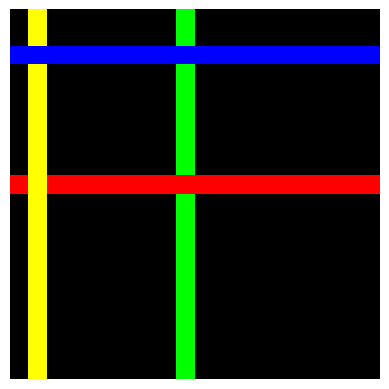

In [235]:
temp = 0
load_image(data, temp).display()
print()

In [237]:
# Set hyperparameters and train model
lr = .01
epsilon = .00002
Lambda, decay = .001, .99
EPOCH_LIM = 500
regularization = (2, Lambda, decay)
ttv_split = train_test_validation_split(image_data, label_data) # train, test, and validation

logistic = LogisticRegression(*ttv_split, lr, epsilon, regularization)
sgd = logistic.train_stochastic(EPOCH_LIM)
predictions = logistic.get_pred_labels(logistic.predict())

Epoch		TrainLoss	ValLoss		TrainAcc	ValAcc
0		23.787		25.242		56.85%		52.6%


C:\Users\kc590\AppData\Local\Temp\ipykernel_5224\1291923208.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


1		35.14		35.812		60.32%		58.6%
2		49.896		50.941		63.25%		60.2%
3		62.846		63.264		67.62%		66.2%
4		76.602		76.99		66.88%		65.4%
5		88.205		87.692		71.55%		73.0%
6		97.69		98.532		70.05%		67.8%
7		105.639		105.67		74.2%		74.2%
8		113.137		112.707		74.45%		75.6%
9		119.241		119.692		75.3%		74.0%
10		123.385		124.666		74.75%		71.0%
11		127.152		126.398		75.2%		77.2%
12		129.97		129.968		75.15%		75.4%
13		131.851		132.427		75.98%		74.4%
14		133.861		133.965		76.58%		76.2%
15		135.405		135.243		76.35%		76.8%
16		137.808		139.168		76.05%		72.2%
17		137.874		137.584		78.42%		79.4%
18		138.473		139.202		78.83%		76.8%
19		138.437		137.672		79.1%		81.6%
20		139.523		139.61		75.7%		75.6%
21		138.939		138.415		77.65%		79.2%
22		138.006		139.938		78.5%		73.0%
23		138.865		140.633		79.1%		74.0%
24		139.403		138.697		78.38%		80.4%
25		139.794		139.184		77.15%		79.0%
26		138.402		138.186		78.4%		79.0%
27		137.439		136.52		78.83%		81.6%
28		137.421		137.869		79.75%		78.2%
29		137.431		137.138		78.0%	

TRAINING ACCURACY: 91.6%, 3664/4000
TESTING ACCURACY: 90.8%, 454/500


C:\Users\kc590\AppData\Local\Temp\ipykernel_5224\1291923208.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


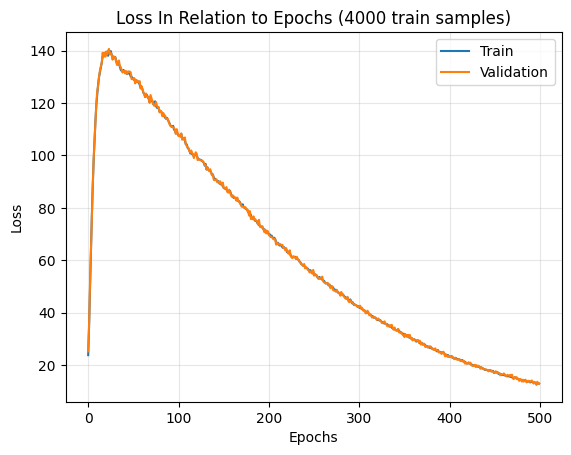

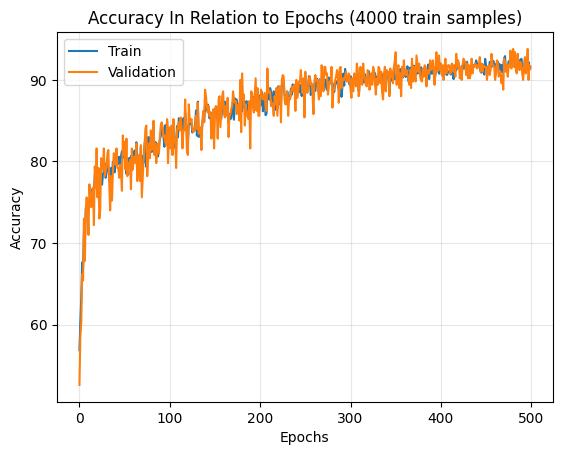

SUM OF WEIGHTS: 14242.784083320612


In [238]:
logistic.test()
print(f"SUM OF WEIGHTS: {sum(abs(logistic.weights))}")

In [ ]:
for k in logistic.weights:
    print(k)

0.05809729137761584
2.38066065116766
0.06001531604190386
-4.003216733192972
0.9487853675983955
1.96367884430801
0.48902461900555366
-2.3370654468338206
-0.29824267051566006
2.892544282382166
-0.14039774178503353
-2.50773868827136
0.4732223563834215
1.873321270611235
-0.25976385330889573
-1.9364813243102268
-0.8832990449266809
2.740098773250663
0.45702850579360393
-3.526197643040276
-1.2304865539733472
1.642379727940842
-1.8201719150664104
-1.3350695794721266
0.9127147460376464
3.1338149958660138
1.3318943607568368
-2.3713451622932937
-0.1312871760689943
3.2052345949383314
0.3487907857060639
-1.9059692237304793
0.10710153931229616
2.364029273306364
-0.4067492579640547
-3.3058247240320155
-0.07015347413567562
1.3460908272637226
-0.2766851686518557
-3.254060608124865
-0.09106940991497718
3.230298272921018
-1.6340485924983443
-2.861530356870371
0.9550476924470763
2.2836642060717893
0.09555481100092875
-3.2700369809408163
-0.31755474725488586
2.987343948672196
-0.3555222069194801
-1.7403340

In [175]:
import numpy as np
from sklearn.linear_model import LogisticRegression as SKLearnLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

diagrams = logistic.X_train
labels = logistic.y_train

diagrams2 = logistic.X_test
labels2 = logistic.y_test

print(diagrams.shape, labels.shape)
print(diagrams2.shape, labels2.shape)

(2000, 2249) (2000,)
(250, 2249) (250,)


In [142]:
model = SKLearnLR(max_iter=250)
model.fit(diagrams, labels)

predictions = model.predict(diagrams2)

accuracy = accuracy_score(labels2, predictions)
print("Test accuracy: ", accuracy)

Test accuracy:  0.896


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


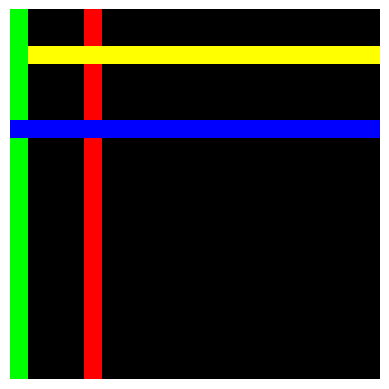

array([[0.22222222, 0.88888889, 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.22222222, 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.33333333, 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.33333333, 0.        , 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.33333333, 0.        , 0.        , 0.        ,
        0.        ]])

In [143]:
# Convolution Testing
data = DataSet()
img_gen = ImageGenerator(5, dataset = data)
img_data = one_hot_encode(data.image_data)
load_image(data, 0).display()
convolved = apply_convolution(img_data, 1)
pooled = apply_pooling(convolved, 3, "mean")
pooled[0, :, :, 0]
# R B Y G
                                                 
                                                

In [111]:
print(len(logistic.X_train[1]))

2249
